In [5]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torch.nn import functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
import copy
import IPython
from torchvision.transforms import Resize
# from pl_bolts.models.autoencoders import AE
# from pytorch_lightning import LightningModule, Trainer, Callback
from torch.utils.data import Dataset
import torch_dct as dct

In [6]:
mean = (0.408, 0.377, 0.352)
std  = (0.269, 0.260, 0.261)
coco = datasets.CocoDetection(root="/disk2/ofirb/dabs/data/captioned_images/mscoco/train2017/",
                              annFile="/disk2/ofirb/dabs/data/captioned_images/mscoco/annotations/instances_train2017.json",
                              transform=transforms.Compose([transforms.Resize((32, 32)),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean, std)])
                             )
coco_loader = DataLoader(coco, batch_size=1)
# resnet50 = models.resnet50(pretrained=True)

loading annotations into memory...
Done (t=118.61s)
creating index...
index created!


In [27]:
res = torch.Tensor([[0,1,2,3,4,5,6,7],[1,1,2,3,4,5,6,7],[2,1,2,3,4,5,6,7],[3,1,2,3,4,5,6,7],[4,1,2,3,4,5,6,7],[5,1,2,3,4,5,6,7],[6,1,2,3,4,5,6,7],[7,1,2,3,4,5,6,7]])
a,b=4,4
print((4*res.mean()-2*(res[a:]).mean() -(res[:a,b:]).mean()))
print(res[:a,:b].mean())


tensor(1.8750)
tensor(1.8750)


In [42]:
import torch
import torch_dct as dct

class LowFreqPenaltyLoss(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self,delta,spatial_shape=(32,32)):
        if len(spatial_shape) == 2:
            res = dct.dct_2d(delta)
            # a = spatial_shape[0]//10
            # b = spatial_shape[1]//10
            a = spatial_shape[0]//4
            b = spatial_shape[1]//4
            # parts = 2*2
            # a = 4
            # b = 4
            return (res[:,:,:a,:b].abs()).mean() #(parts*res.abs().mean() - res[:,:,a:,b:].abs().mean())/(parts-1) 
        
        else:
            raise ValueError(f'LowFreqPenaltyLoss not implemented for spatial_shape: {spatial_shape}')


class HighFreqPenaltyLoss(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self,delta,spatial_shape=(32,32)):
        if len(spatial_shape) == 2:
            res = dct.dct_2d(delta)
            a = spatial_shape[0]//4
            b = spatial_shape[1]//4
            parts = 4 * 4
            # a = 4
            # b = 4
            return (parts*res.abs().mean() - res[:,:,:a,:b].abs().mean())/(parts) #(res[:,:,a:,b:].abs()).mean()
        
        else:
            raise ValueError(f'HighFreqPenaltyLoss not implemented for spatial_shape: {spatial_shape}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


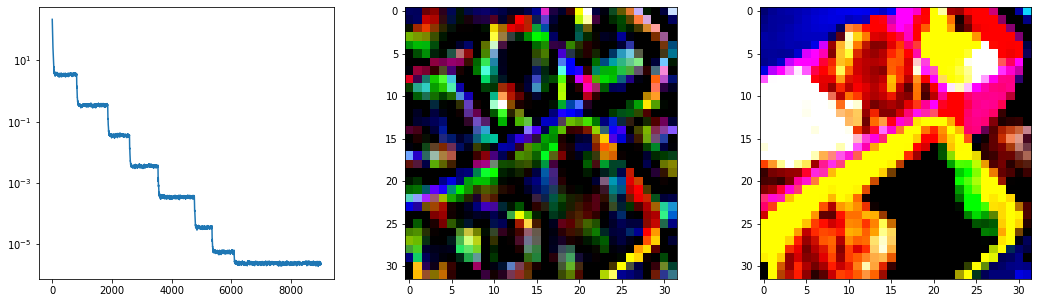

In [43]:
device = 2

# norm = lambda im: (im - im.min())/(im.max()-im.min())
# mean_tensor = torch.tensor(mean, device=device).reshape(1,3,1,1)
# std_tensor = torch.tensor(std, device=device).reshape(1,3,1,1)

# crit = HighFreqPenaltyLoss()
crit = LowFreqPenaltyLoss()

for j, (image, target) in enumerate(coco_loader):
    # if j < 5:
        # continue
    original = torch.clone(image).detach()
    image = image.to(device)
    losses = []
    image.requires_grad = True
    sgd = Adam([image], lr=0.1)
    sched = ReduceLROnPlateau(sgd, verbose=True, patience=500)
    for i in range(10000):
        sgd.zero_grad()
        loss = crit(image, (image.shape[-2],image.shape[-1]))
        loss.backward()
        sgd.step()
        sched.step(loss)
        losses.append(loss.cpu().item())
        if i%1000==0:
            IPython.display.clear_output(wait=True)
            plt.figure(figsize=(18,5))
            plt.subplot(131)
            plt.yscale("log")
            plt.plot(losses)
            plt.subplot(132)
            plt.imshow(image[0].detach().cpu().permute(1,2,0))
            plt.subplot(133)
            plt.imshow(original[0].permute(1,2,0))
            plt.show()
            plt.close()
    prev_im = image
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


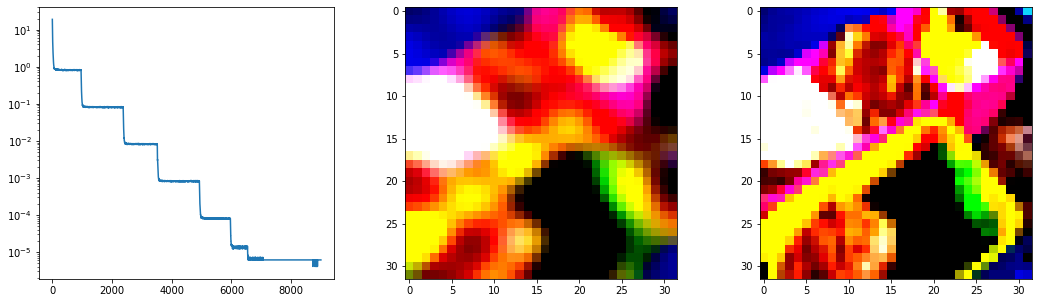

In [32]:
device = 1

# norm = lambda im: (im - im.min())/(im.max()-im.min())
# mean_tensor = torch.tensor(mean, device=device).reshape(1,3,1,1)
# std_tensor = torch.tensor(std, device=device).reshape(1,3,1,1)

crit = HighFreqPenaltyLoss()
# crit = LowFreqPenaltyLoss()

for j, (image, target) in enumerate(coco_loader):
    # if j < 5:
        # continue
    original = torch.clone(image).detach()
    image = image.to(device)
    losses = []
    image.requires_grad = True
    sgd = Adam([image], lr=0.1)
    sched = ReduceLROnPlateau(sgd, verbose=True, patience=500)
    for i in range(10000):
        sgd.zero_grad()
        loss = crit(image, (image.shape[-2],image.shape[-1]))
        loss.backward()
        sgd.step()
        sched.step(loss)
        losses.append(loss.cpu().item())
        if i%1000==0:
            IPython.display.clear_output(wait=True)
            plt.figure(figsize=(18,5))
            plt.subplot(131)
            plt.yscale("log")
            plt.plot(losses)
            plt.subplot(132)
            plt.imshow(image[0].detach().cpu().permute(1,2,0))
            plt.subplot(133)
            plt.imshow(original[0].permute(1,2,0))
            plt.show()
            plt.close()
    prev_im = image
    break